----- Training GMM Network -----
[GMM] Epoch 1/200 | Loss: 0.1137
[GMM] Epoch 2/200 | Loss: -0.1007
[GMM] Epoch 3/200 | Loss: -0.2107
[GMM] Epoch 4/200 | Loss: -0.3704
[GMM] Epoch 5/200 | Loss: -0.1752
[GMM] Epoch 6/200 | Loss: -0.2773
[GMM] Epoch 7/200 | Loss: -0.5991
[GMM] Epoch 8/200 | Loss: -0.8561
[GMM] Epoch 9/200 | Loss: -1.5364
[GMM] Epoch 10/200 | Loss: -0.7234
[GMM] Epoch 11/200 | Loss: -1.6389
[GMM] Epoch 12/200 | Loss: -1.9975
[GMM] Epoch 13/200 | Loss: -2.1974
[GMM] Epoch 14/200 | Loss: -1.8990
[GMM] Epoch 15/200 | Loss: -1.6421
[GMM] Epoch 16/200 | Loss: -1.2803
[GMM] Epoch 17/200 | Loss: -1.0774
[GMM] Epoch 18/200 | Loss: -2.2722
[GMM] Epoch 19/200 | Loss: -1.9520
[GMM] Epoch 20/200 | Loss: -1.6660
[GMM] Epoch 21/200 | Loss: -2.3229
[GMM] Epoch 22/200 | Loss: -2.4365
[GMM] Epoch 23/200 | Loss: -1.2348
[GMM] Epoch 24/200 | Loss: -1.4694
[GMM] Epoch 25/200 | Loss: -2.2812
[GMM] Epoch 26/200 | Loss: -1.0371
[GMM] Epoch 27/200 | Loss: -1.6410
[GMM] Epoch 28/200 | Loss: -2.36

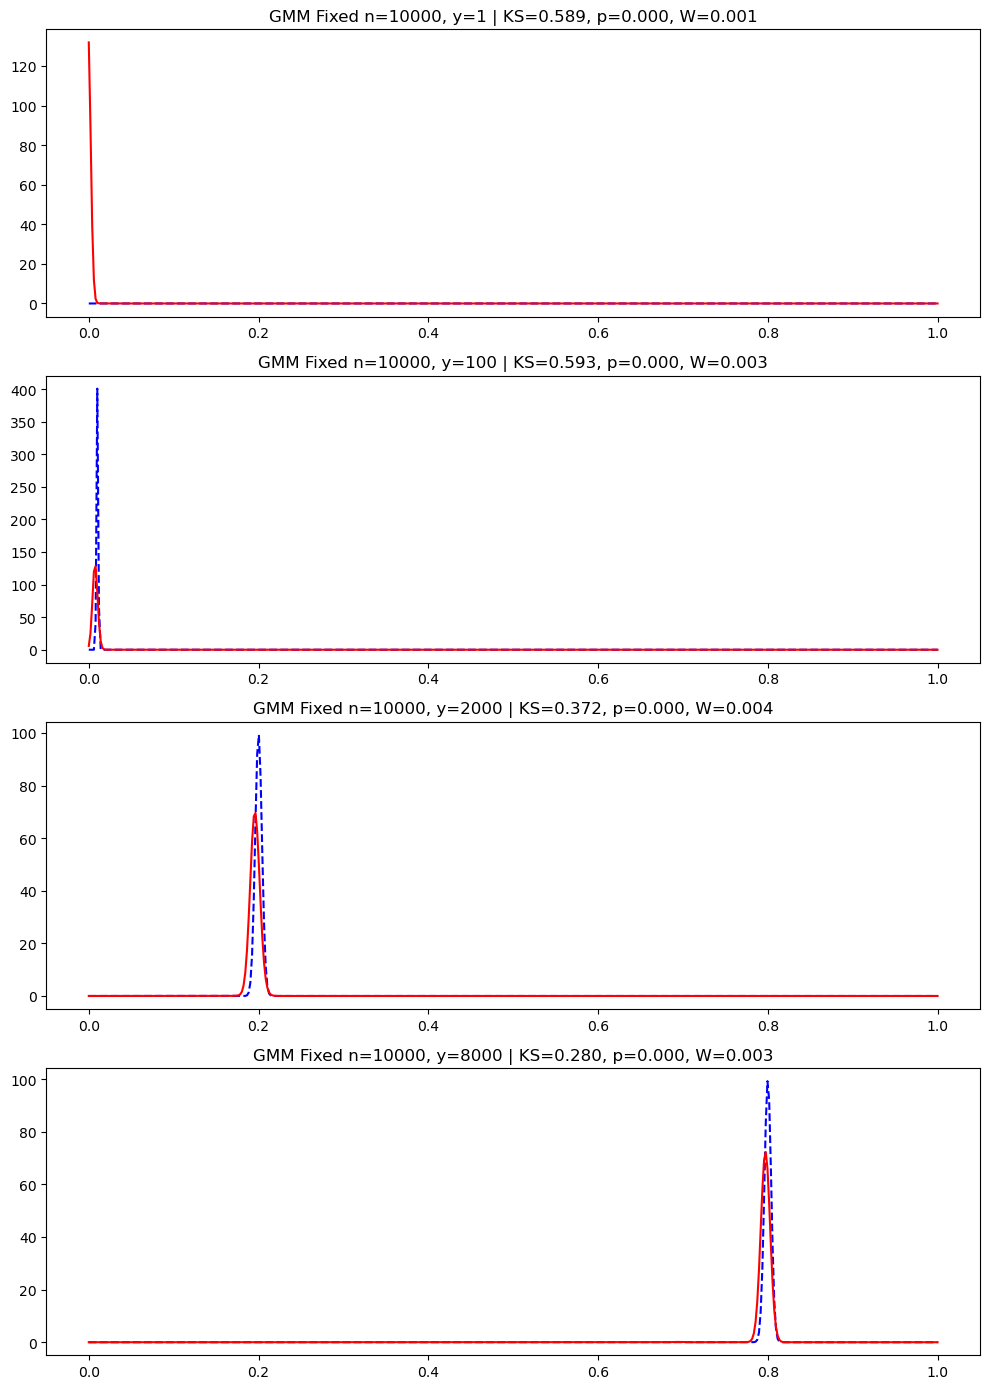

----- Evaluating GMM Unseen n's -----


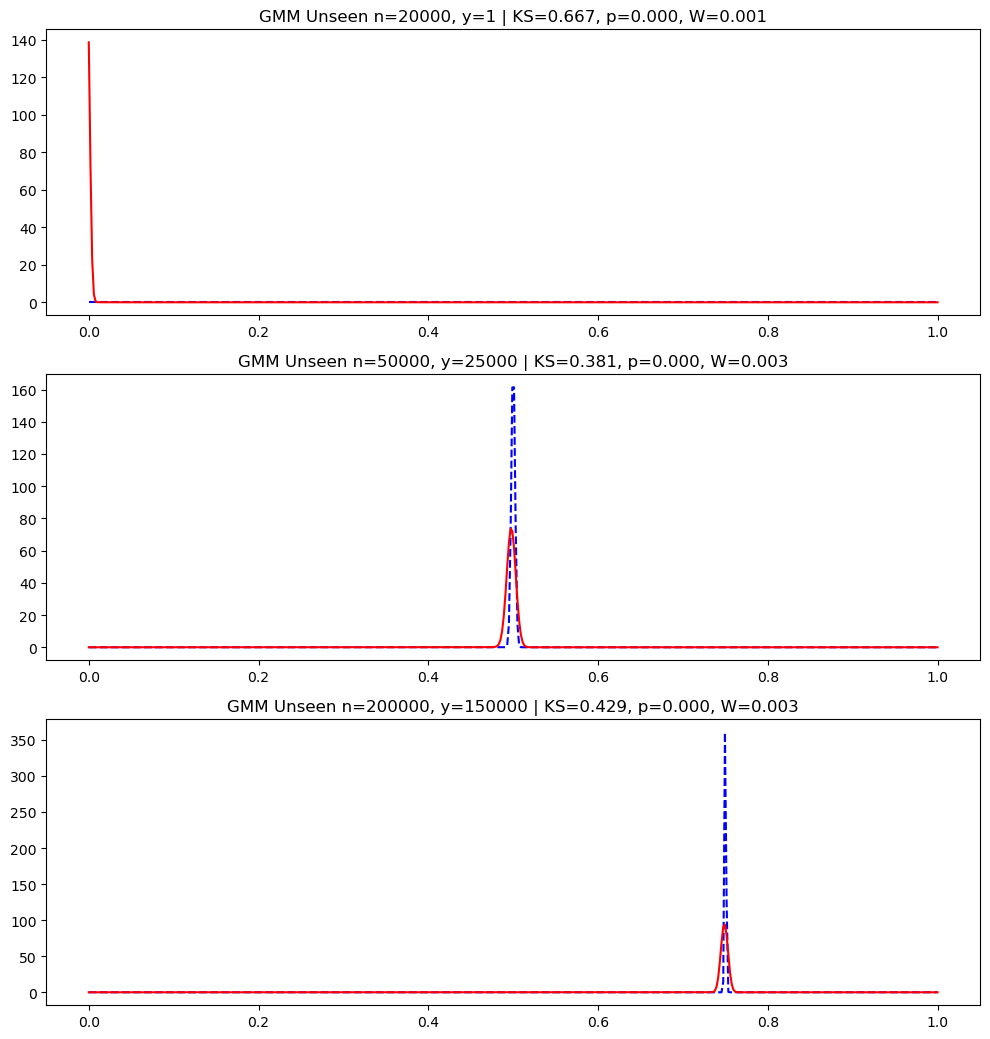

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import beta, norm, ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import os

os.makedirs("plots", exist_ok=True)

def generate_theta_y_n_large(batch_size=256, n_min=50, n_max=100_000, log_uniform=True):
    if log_uniform:
        log_n = np.random.uniform(np.log(n_min), np.log(n_max), size=(batch_size, 1))
        n = np.round(np.exp(log_n)).astype(np.float32)
    else:
        n = np.random.randint(n_min, n_max + 1, size=(batch_size, 1)).astype(np.float32)
    theta = np.random.uniform(0, 1, size=(batch_size, 1)).astype(np.float32)
    y = np.random.binomial(n=n.astype(int), p=theta).astype(np.float32)
    return y, n, theta

def gmm_log_likelihood(theta, logits, mus, log_sigmas):
    log_sigmas = torch.clamp(log_sigmas, min=-5, max=3)
    sigmas = torch.exp(log_sigmas)
    pi = torch.softmax(logits, dim=1)
    th = theta.unsqueeze(1).expand(-1, mus.size(1))
    logp = -0.5 * ((th - mus) / sigmas) ** 2 - log_sigmas - 0.5 * np.log(2 * np.pi)
    wlogp = logp + torch.log(pi + 1e-10)
    return -torch.mean(torch.logsumexp(wlogp, dim=1))

class GMMInferenceNet(nn.Module):
    def __init__(self, num_components=3, hidden_dims=(512, 512, 256, 128)):
        super().__init__()
        self.K = num_components
        layers = []
        d = 2
        for h in hidden_dims:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers.append(nn.Linear(d, 3 * self.K))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out[:, :self.K], out[:, self.K:2*self.K], out[:, 2*self.K:]

def train_gmm_network(model, optimizer, num_epochs=200, batch_size=256, n_min=50, n_max=100_000, steps_per_epoch=100):
    for epoch in range(num_epochs):
        total_loss = 0.0
        for _ in range(steps_per_epoch):
            y_np, n_np, theta_np = generate_theta_y_n_large(batch_size, n_min, n_max)
            x = torch.cat([
                torch.from_numpy(y_np / n_np),
                torch.from_numpy(np.log(n_np))
            ], dim=1).float()
            theta = torch.from_numpy(theta_np).squeeze(1).float()
            logits, mus, logs = model(x)
            pi = torch.softmax(logits, dim=1)
            nll = gmm_log_likelihood(theta, logits, mus, logs)
            entropy = -torch.sum(pi * torch.log(pi + 1e-8), dim=1).mean()
            loss = nll - 0.01 * entropy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[GMM] Epoch {epoch + 1}/{num_epochs} | Loss: {total_loss / steps_per_epoch:.4f}")

def evaluate_gmm_fixed_n(model, fixed_n, y_values, theta_grid, num_components=3):
    plt.figure(figsize=(10, 3.5 * len(y_values)))
    for i, y in enumerate(y_values):
        alpha, beta_param = y + 1, fixed_n - y + 1
        true_pdf = beta.pdf(theta_grid, alpha, beta_param)
        x = torch.tensor([[y / fixed_n, np.log(fixed_n)]], dtype=torch.float32)
        with torch.no_grad():
            logits, mus, logs = model(x)
        pi = torch.softmax(logits, dim=1).numpy().flatten()
        mus = mus.numpy().flatten()
        sig = np.exp(logs.numpy()).flatten()
        gmm_pdf = sum(pi[k] * norm.pdf(theta_grid, mus[k], sig[k]) for k in range(num_components))
        ts = beta.rvs(alpha, beta_param, size=2000)
        ss = np.clip(np.hstack([
            np.random.normal(mus[k], sig[k], int(round(pi[k] * 2000)))
            for k in range(num_components)
        ]), 0, 1)
        ks, p = ks_2samp(ts, ss)
        wd = wasserstein_distance(ts, ss)
        ax = plt.subplot(len(y_values), 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--')
        ax.plot(theta_grid, gmm_pdf, 'r-')
        ax.set_title(f"GMM Fixed n={fixed_n}, y={y} | KS={ks:.3f}, p={p:.3f}, W={wd:.3f}")
    plt.tight_layout()
    plt.savefig(f"plots/gmm_fixedN_{fixed_n}.png", dpi=300)
    plt.show()

def evaluate_gmm_unseen_n(model, test_cases, theta_grid, num_components=3):
    plt.figure(figsize=(10, 3.5 * len(test_cases)))
    for i, (n, y) in enumerate(test_cases):
        alpha, beta_param = y + 1, n - y + 1
        true_pdf = beta.pdf(theta_grid, alpha, beta_param)
        x = torch.tensor([[y / n, np.log(n)]], dtype=torch.float32)
        with torch.no_grad():
            logits, mus, logs = model(x)
        pi = torch.softmax(logits, dim=1).numpy().flatten()
        mus = mus.numpy().flatten()
        sig = np.exp(logs.numpy()).flatten()
        gmm_pdf = sum(pi[k] * norm.pdf(theta_grid, mus[k], sig[k]) for k in range(num_components))
        ts = beta.rvs(alpha, beta_param, size=2000)
        ss = np.clip(np.hstack([
            np.random.normal(mus[k], sig[k], int(round(pi[k] * 2000)))
            for k in range(num_components)
        ]), 0, 1)
        ks, p = ks_2samp(ts, ss)
        wd = wasserstein_distance(ts, ss)
        ax = plt.subplot(len(test_cases), 1, i + 1)
        ax.plot(theta_grid, true_pdf, 'b--')
        ax.plot(theta_grid, gmm_pdf, 'r-')
        ax.set_title(f"GMM Unseen n={n}, y={y} | KS={ks:.3f}, p={p:.3f}, W={wd:.3f}")
    plt.tight_layout()
    plt.savefig("plots/gmm_unseenN.png", dpi=300)
    plt.show()

K = 10  
hidden_dims = (512, 512, 256, 128)
gmm_model = GMMInferenceNet(num_components=K, hidden_dims=hidden_dims)
gmm_optimizer = optim.Adam(gmm_model.parameters(), lr=1e-3)
print("----- Training GMM Network -----")
train_gmm_network(gmm_model, gmm_optimizer)

theta_grid = np.linspace(0, 1, 500)
y_values_fixed = [1, 100, 2000, 8000]
test_cases_unseen = [(20000, 1), (50000, 25000), (200000, 150000)]

print("----- Evaluating GMM Fixed n=10000 -----")
evaluate_gmm_fixed_n(gmm_model, fixed_n=10000, y_values=y_values_fixed, theta_grid=theta_grid, num_components=K)
print("----- Evaluating GMM Unseen n's -----")
evaluate_gmm_unseen_n(gmm_model, test_cases_unseen, theta_grid, num_components=K)


[GMM] Epoch 1/200 | Loss: -0.0650
[GMM] Epoch 2/200 | Loss: -0.0777
[GMM] Epoch 3/200 | Loss: -0.6125
[GMM] Epoch 4/200 | Loss: -0.9730
[GMM] Epoch 5/200 | Loss: -0.9741
[GMM] Epoch 6/200 | Loss: -0.9720
[GMM] Epoch 7/200 | Loss: -1.1030
[GMM] Epoch 8/200 | Loss: -1.1597
[GMM] Epoch 9/200 | Loss: -1.3764
[GMM] Epoch 10/200 | Loss: -1.2771
[GMM] Epoch 11/200 | Loss: -1.6658
[GMM] Epoch 12/200 | Loss: -1.7438
[GMM] Epoch 13/200 | Loss: -1.7035
[GMM] Epoch 14/200 | Loss: -1.7264
[GMM] Epoch 15/200 | Loss: -1.7591
[GMM] Epoch 16/200 | Loss: -1.6976
[GMM] Epoch 17/200 | Loss: -1.7799
[GMM] Epoch 18/200 | Loss: -1.7774
[GMM] Epoch 19/200 | Loss: -1.8187
[GMM] Epoch 20/200 | Loss: -1.7714
[GMM] Epoch 21/200 | Loss: -1.8013
[GMM] Epoch 22/200 | Loss: -1.8202
[GMM] Epoch 23/200 | Loss: -1.8140
[GMM] Epoch 24/200 | Loss: -1.8290
[GMM] Epoch 25/200 | Loss: -1.7804
[GMM] Epoch 26/200 | Loss: -1.7964
[GMM] Epoch 27/200 | Loss: -1.8105
[GMM] Epoch 28/200 | Loss: -1.8138
[GMM] Epoch 29/200 | Loss: -1

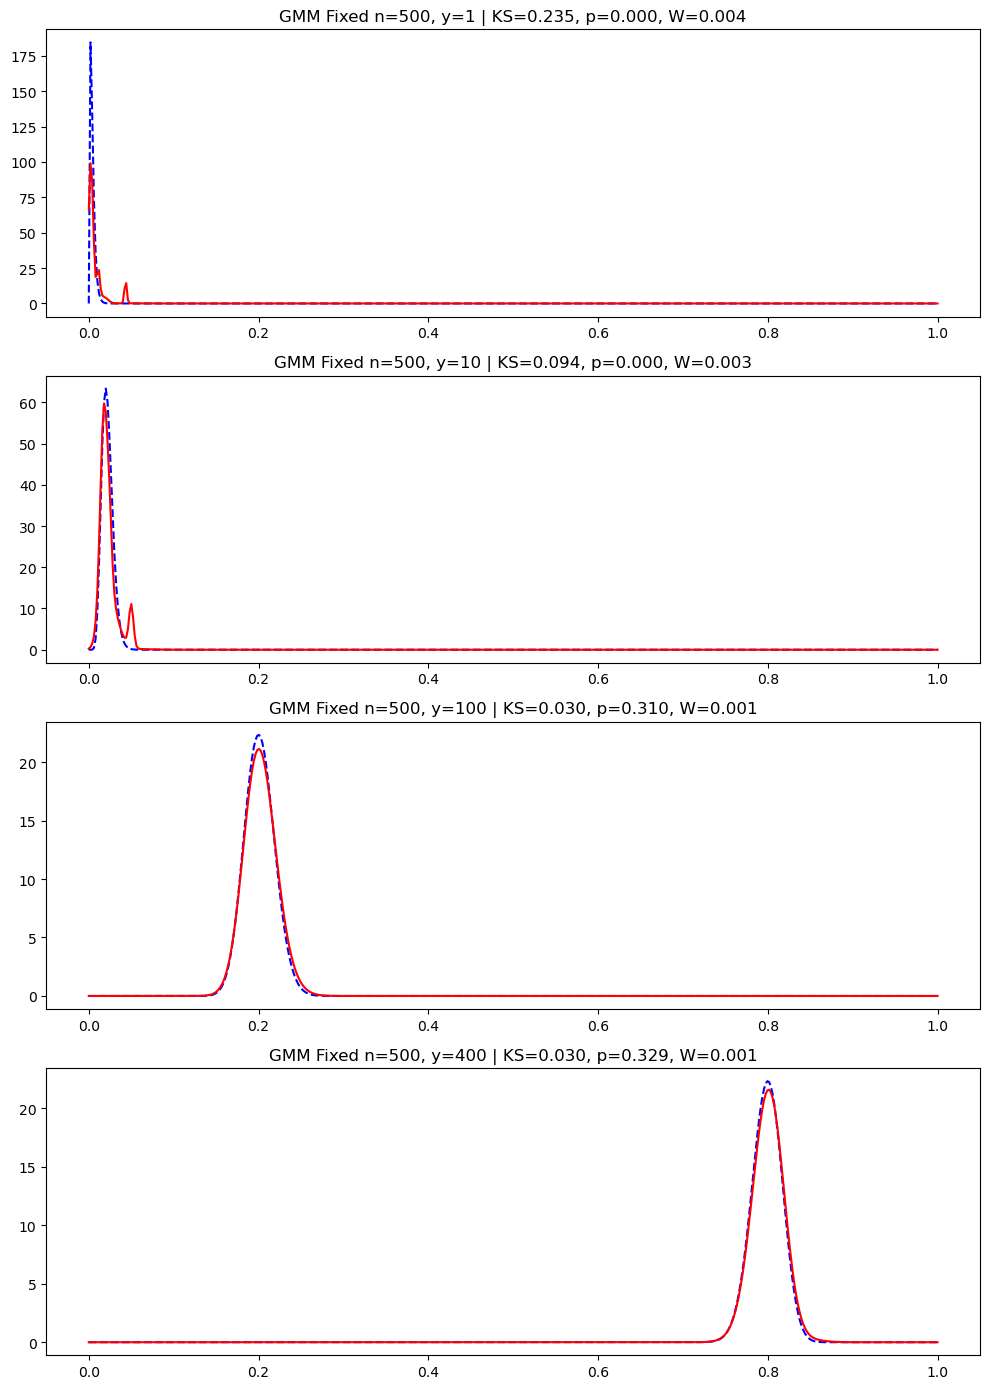

----- Evaluating GMM Unseen n's -----


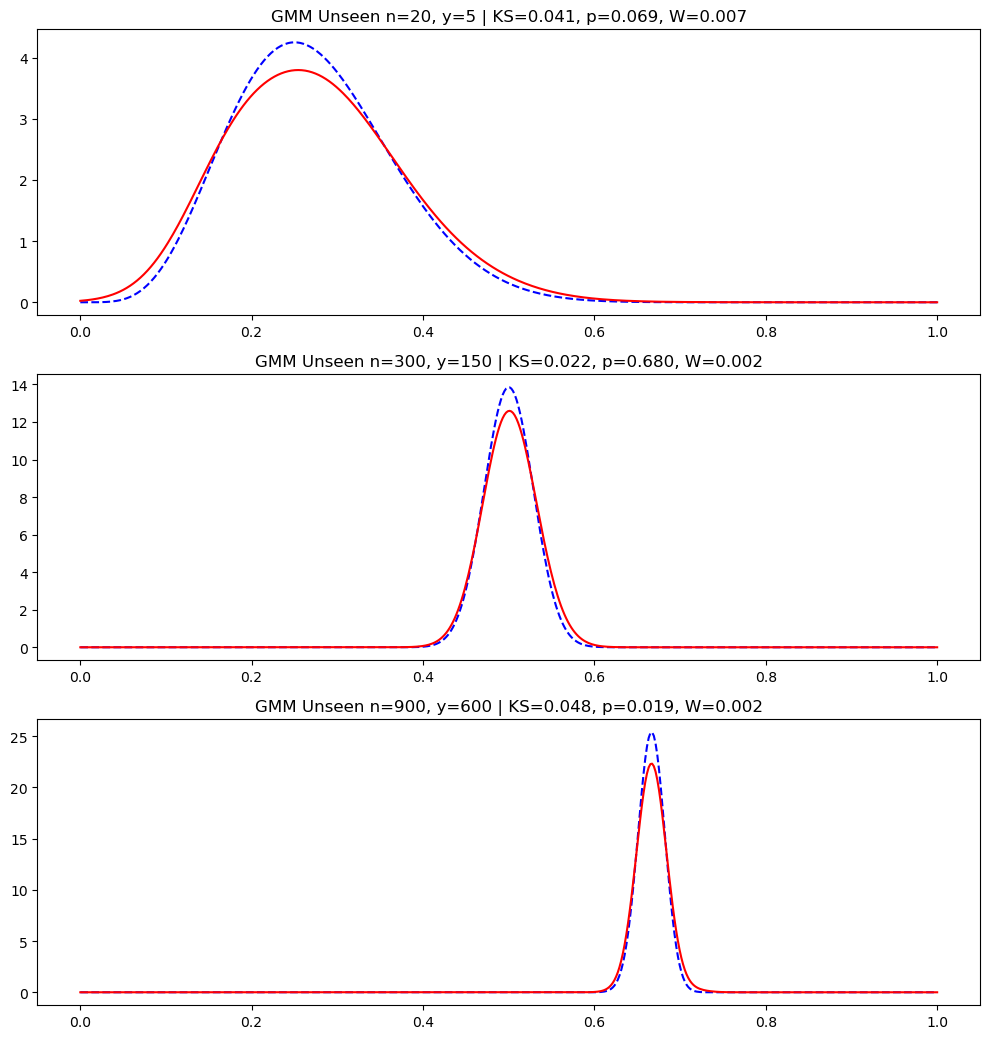

In [7]:

K = 10
hidden_dims = (512, 512, 256, 128)
gmm_model = GMMInferenceNet(num_components=K, hidden_dims=hidden_dims)
gmm_optimizer = optim.Adam(gmm_model.parameters(), lr=1e-3)


# Train the model with moderate n
train_gmm_network(
    model=gmm_model,
    optimizer=gmm_optimizer,
    num_epochs=200,
    batch_size=256,
    n_min=10,
    n_max=1000,
    steps_per_epoch=100
)

# Evaluation
theta_grid = np.linspace(0, 1, 500)
y_values_fixed = [1, 10, 100, 400]
test_cases_unseen = [(20, 5), (300, 150), (900, 600)]

print("----- Evaluating GMM Fixed n=500 -----")
evaluate_gmm_fixed_n(
    model=gmm_model,
    fixed_n=500,
    y_values=y_values_fixed,
    theta_grid=theta_grid,
    num_components=K
)

print("----- Evaluating GMM Unseen n's -----")
evaluate_gmm_unseen_n(
    model=gmm_model,
    test_cases=test_cases_unseen,
    theta_grid=theta_grid,
    num_components=K
)


[GMM] Epoch 1/200 | Loss: -0.1152
[GMM] Epoch 2/200 | Loss: -0.0482
[GMM] Epoch 3/200 | Loss: 0.1938
[GMM] Epoch 4/200 | Loss: -0.4355
[GMM] Epoch 5/200 | Loss: -1.1382
[GMM] Epoch 6/200 | Loss: -1.5505
[GMM] Epoch 7/200 | Loss: -1.7114
[GMM] Epoch 8/200 | Loss: -1.7406
[GMM] Epoch 9/200 | Loss: -1.7748
[GMM] Epoch 10/200 | Loss: -1.7588
[GMM] Epoch 11/200 | Loss: -1.5980
[GMM] Epoch 12/200 | Loss: -1.7018
[GMM] Epoch 13/200 | Loss: -1.7596
[GMM] Epoch 14/200 | Loss: -1.7240
[GMM] Epoch 15/200 | Loss: -1.7616
[GMM] Epoch 16/200 | Loss: -1.7796
[GMM] Epoch 17/200 | Loss: -1.7558
[GMM] Epoch 18/200 | Loss: -1.8006
[GMM] Epoch 19/200 | Loss: -1.8237
[GMM] Epoch 20/200 | Loss: -1.5329
[GMM] Epoch 21/200 | Loss: -1.6974
[GMM] Epoch 22/200 | Loss: -1.8116
[GMM] Epoch 23/200 | Loss: -1.7838
[GMM] Epoch 24/200 | Loss: -1.8429
[GMM] Epoch 25/200 | Loss: -1.8140
[GMM] Epoch 26/200 | Loss: -1.6889
[GMM] Epoch 27/200 | Loss: -1.8040
[GMM] Epoch 28/200 | Loss: -1.7804
[GMM] Epoch 29/200 | Loss: -1.

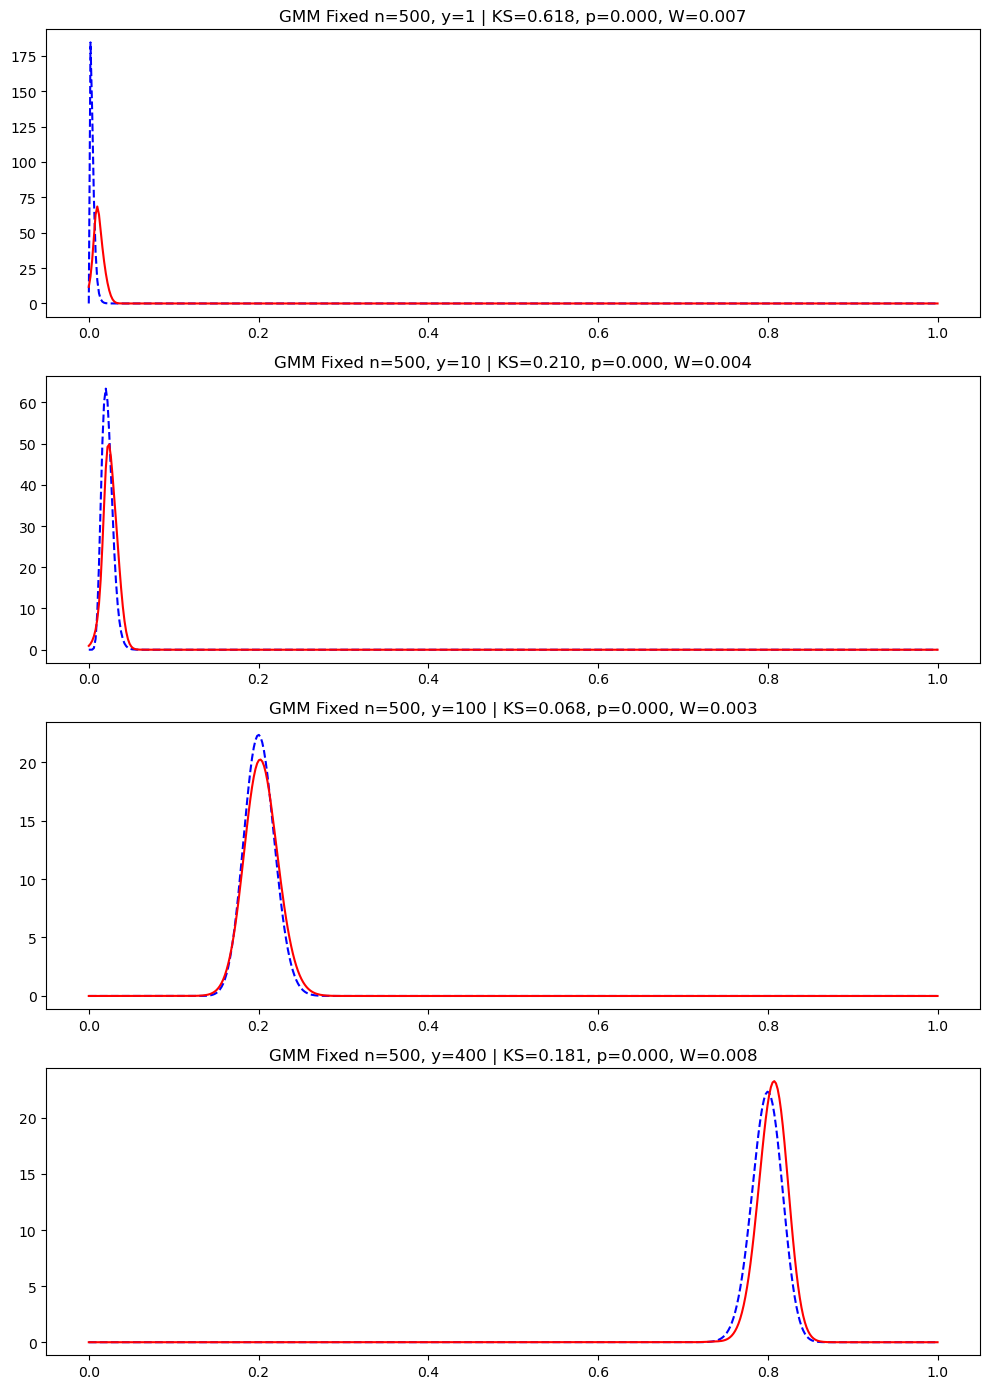

----- Evaluating GMM Unseen n's -----


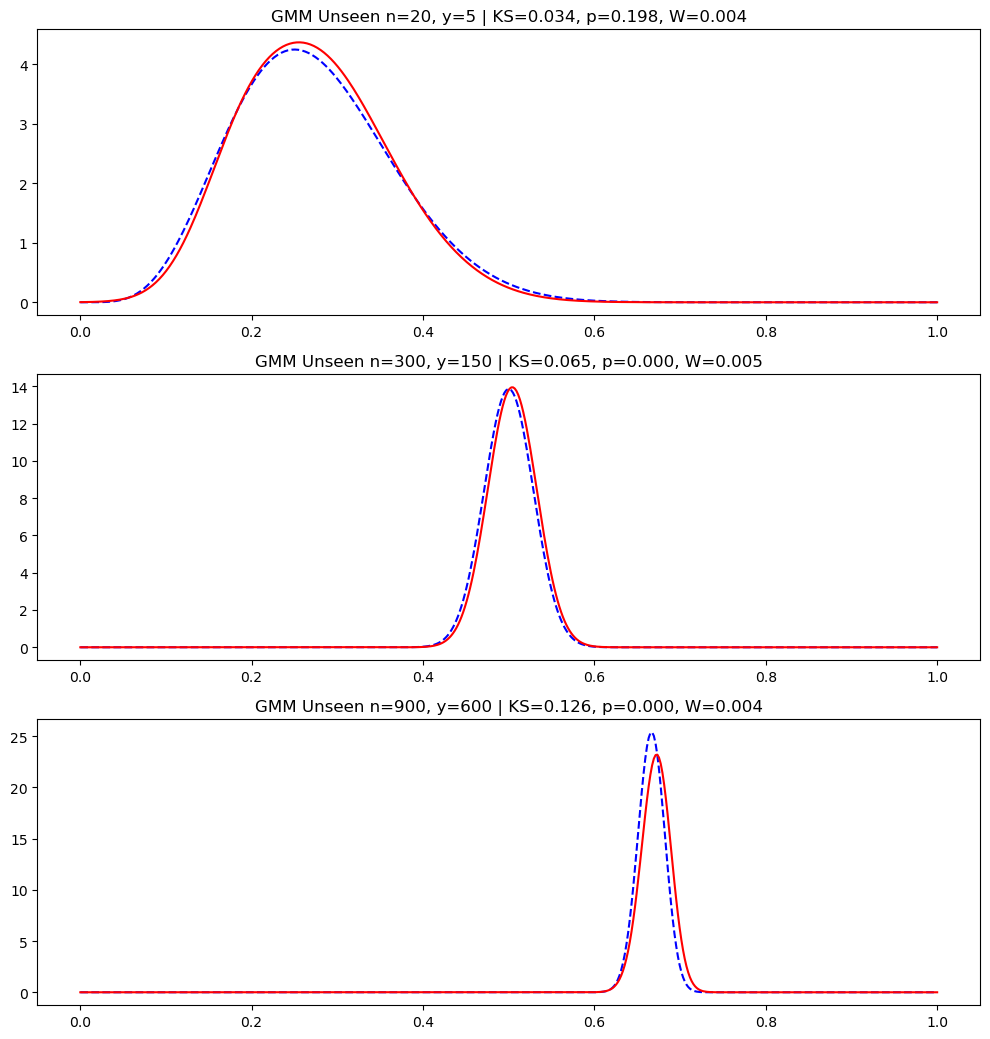

In [3]:

K = 10
hidden_dims = (512, 512, 256, 128)
gmm_model = GMMInferenceNet(num_components=K, hidden_dims=hidden_dims)
gmm_optimizer = optim.Adam(gmm_model.parameters(), lr=1e-3)


train_gmm_network(
    model=gmm_model,
    optimizer=gmm_optimizer,
    num_epochs=200,
    batch_size=256,
    n_min=10,
    n_max=1000,
    steps_per_epoch=100
)

# Evaluation
theta_grid = np.linspace(0, 1, 500)
y_values_fixed = [1, 10, 100, 400]
test_cases_unseen = [(20, 5), (300, 150), (900, 600)]

print("----- Evaluating GMM Fixed n=500 -----")
evaluate_gmm_fixed_n(
    model=gmm_model,
    fixed_n=500,
    y_values=y_values_fixed,
    theta_grid=theta_grid,
    num_components=K
)

print("----- Evaluating GMM Unseen n's -----")
evaluate_gmm_unseen_n(
    model=gmm_model,
    test_cases=test_cases_unseen,
    theta_grid=theta_grid,
    num_components=K
)


[GMM] Epoch 1/200 | Loss: 0.2084
[GMM] Epoch 2/200 | Loss: -0.2147
[GMM] Epoch 3/200 | Loss: -0.4957
[GMM] Epoch 4/200 | Loss: -0.1100
[GMM] Epoch 5/200 | Loss: -0.2921
[GMM] Epoch 6/200 | Loss: -0.7254
[GMM] Epoch 7/200 | Loss: 0.0748
[GMM] Epoch 8/200 | Loss: 0.0685
[GMM] Epoch 9/200 | Loss: 0.2735
[GMM] Epoch 10/200 | Loss: -0.0038
[GMM] Epoch 11/200 | Loss: 0.3552
[GMM] Epoch 12/200 | Loss: 0.0814
[GMM] Epoch 13/200 | Loss: -0.4151
[GMM] Epoch 14/200 | Loss: -0.5585
[GMM] Epoch 15/200 | Loss: -1.0532
[GMM] Epoch 16/200 | Loss: -0.4640
[GMM] Epoch 17/200 | Loss: -0.5909
[GMM] Epoch 18/200 | Loss: -1.3123
[GMM] Epoch 19/200 | Loss: -1.3509
[GMM] Epoch 20/200 | Loss: -1.6212
[GMM] Epoch 21/200 | Loss: -1.9747
[GMM] Epoch 22/200 | Loss: -1.9783
[GMM] Epoch 23/200 | Loss: -2.3353
[GMM] Epoch 24/200 | Loss: -2.4758
[GMM] Epoch 25/200 | Loss: -2.4939
[GMM] Epoch 26/200 | Loss: -2.2376
[GMM] Epoch 27/200 | Loss: -2.5973
[GMM] Epoch 28/200 | Loss: -2.5747
[GMM] Epoch 29/200 | Loss: -2.5733


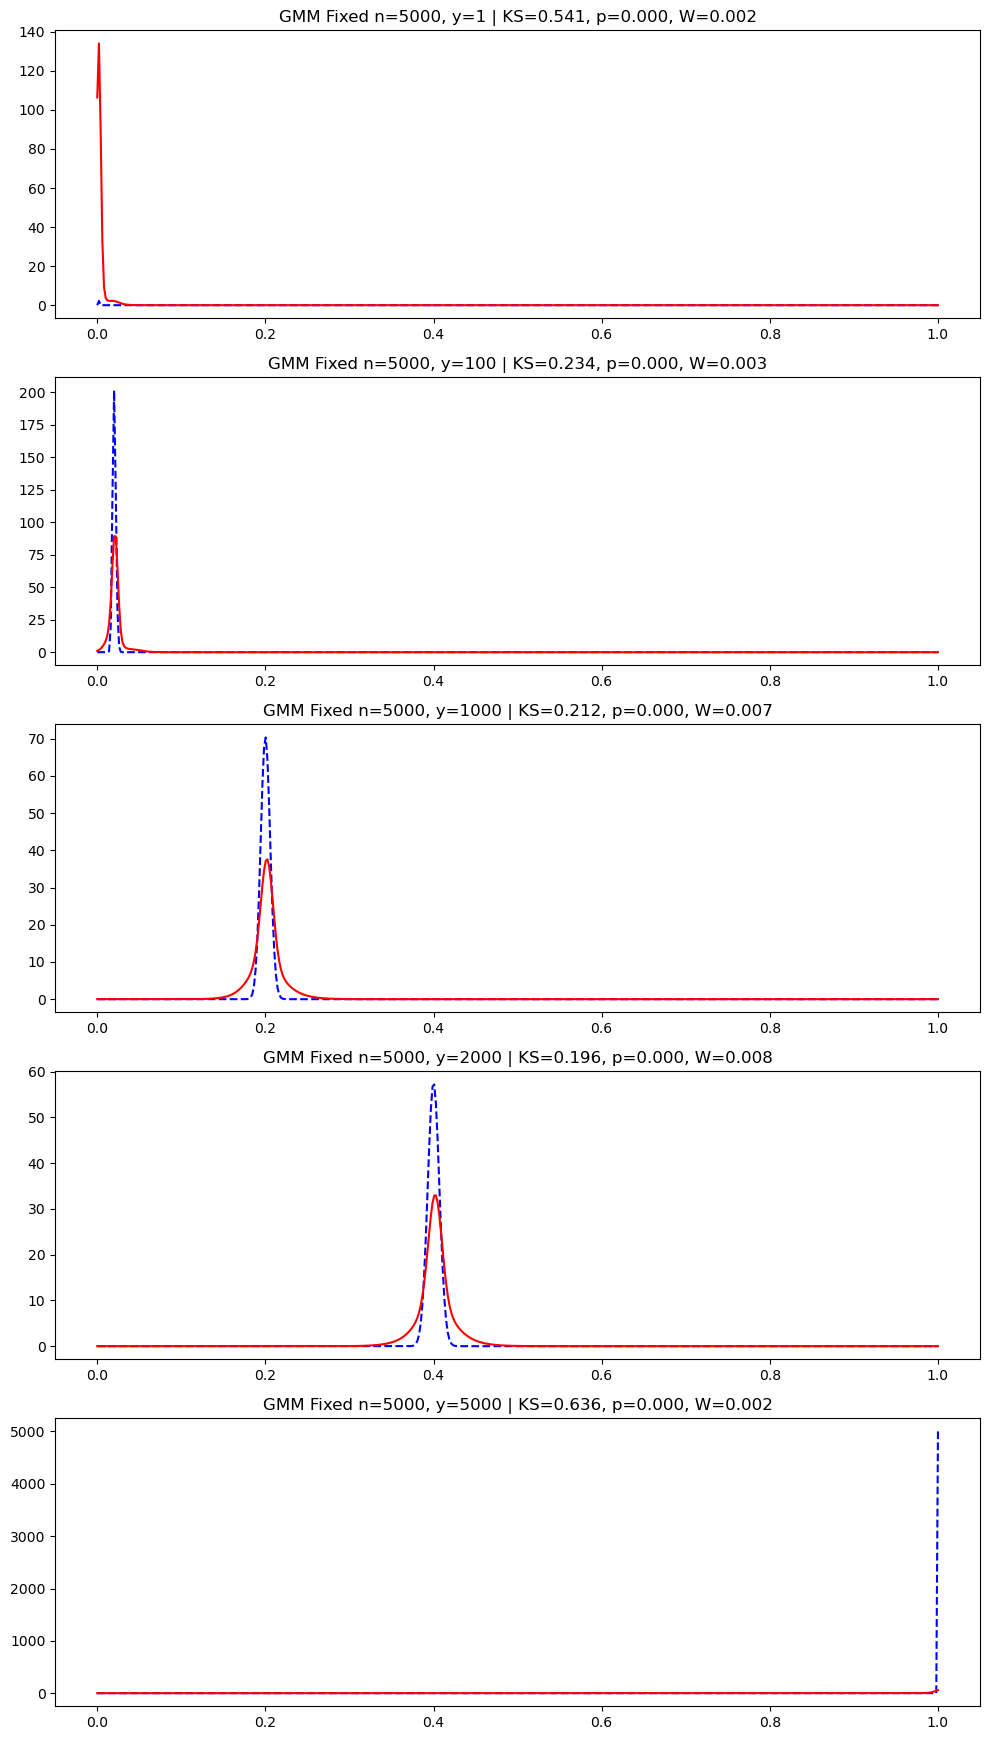

----- Evaluating GMM Unseen n's -----


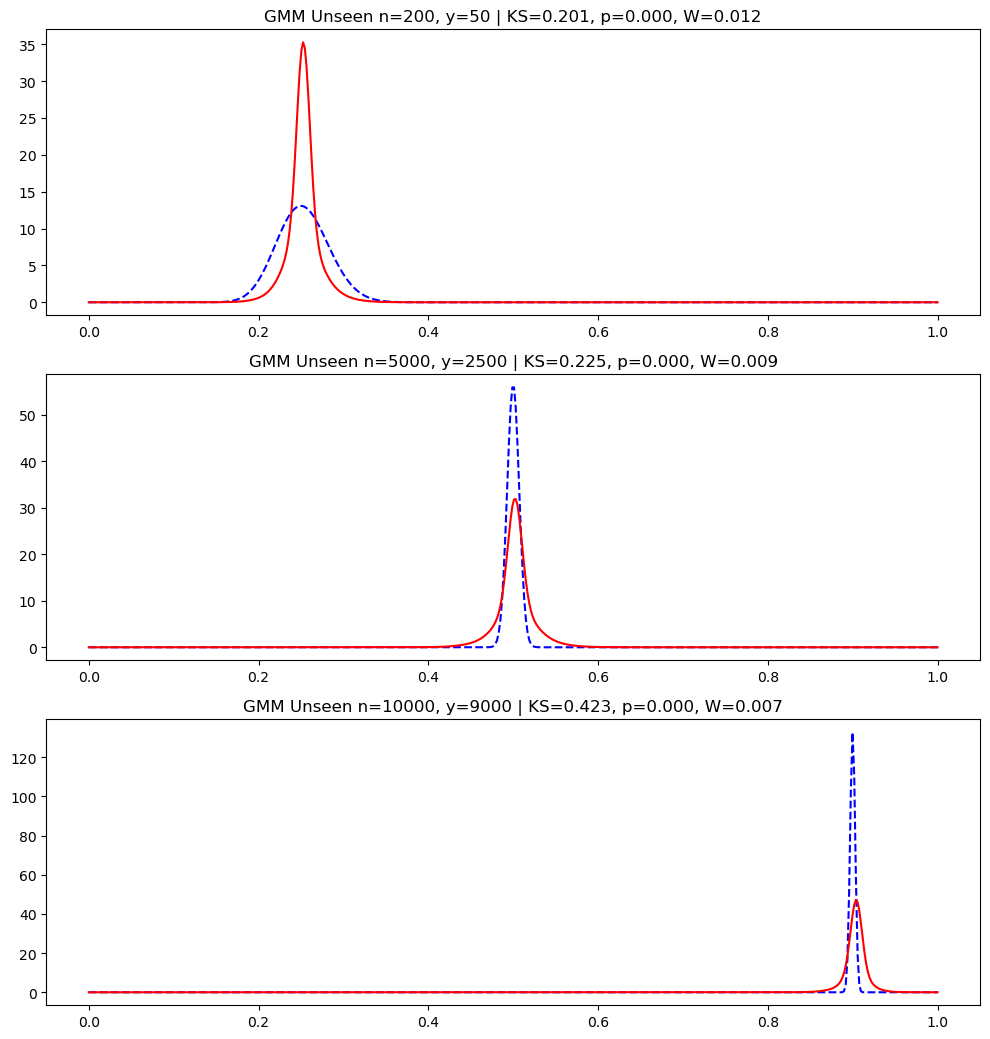

In [8]:


K = 10
hidden_dims = (512, 512, 256, 128)
gmm_model = GMMInferenceNet(num_components=K, hidden_dims=hidden_dims)
gmm_optimizer = optim.Adam(gmm_model.parameters(), lr=1e-3)


train_gmm_network(
    model=gmm_model,
    optimizer=gmm_optimizer,
    num_epochs=200,
    batch_size=256,
    n_min=100,
    n_max=10000,
    steps_per_epoch=100
)

# Evaluation
theta_grid = np.linspace(0, 1, 500)
y_values_fixed = [1, 100, 1000, 2000, 5000]
test_cases_unseen = [(200, 50), (5000, 2500), (10000, 9000)]

print("----- Evaluating GMM Fixed n=5000 -----")
evaluate_gmm_fixed_n(
    model=gmm_model,
    fixed_n=5000,
    y_values=y_values_fixed,
    theta_grid=theta_grid,
    num_components=K
)

print("----- Evaluating GMM Unseen n's -----")
evaluate_gmm_unseen_n(
    model=gmm_model,
    test_cases=test_cases_unseen,
    theta_grid=theta_grid,
    num_components=K
)


----- Evaluating GMM Fixed n=5000 -----


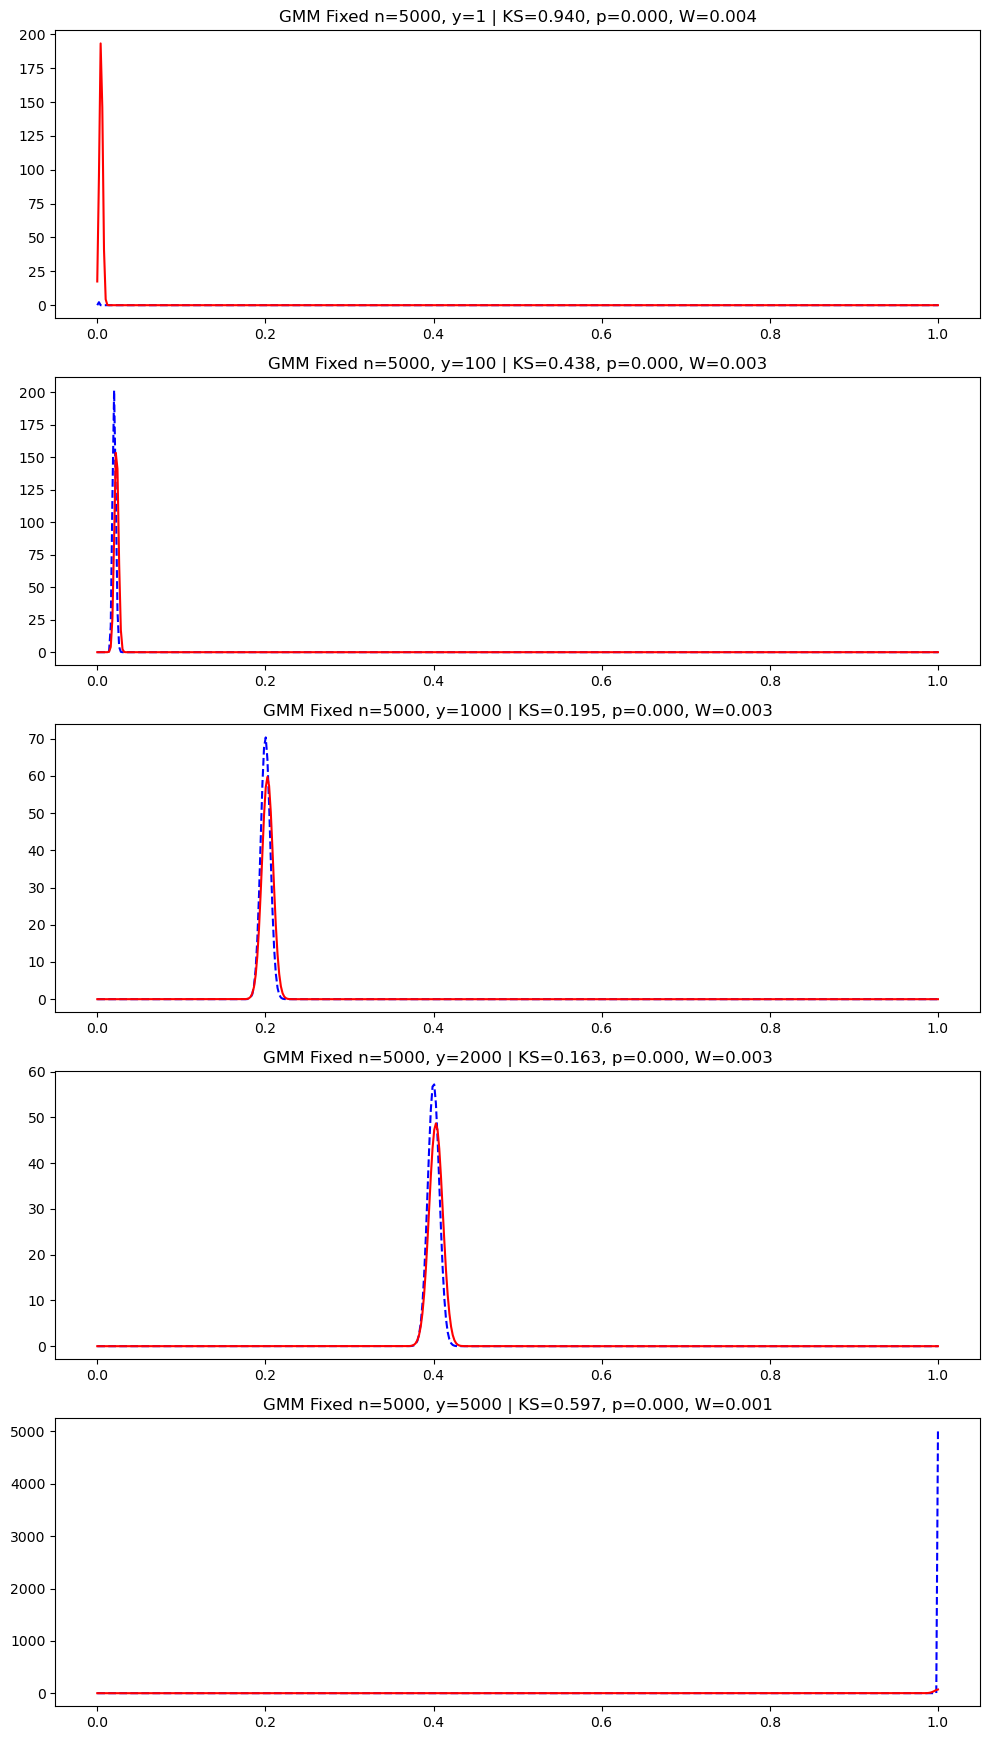

----- Evaluating GMM Unseen n's -----


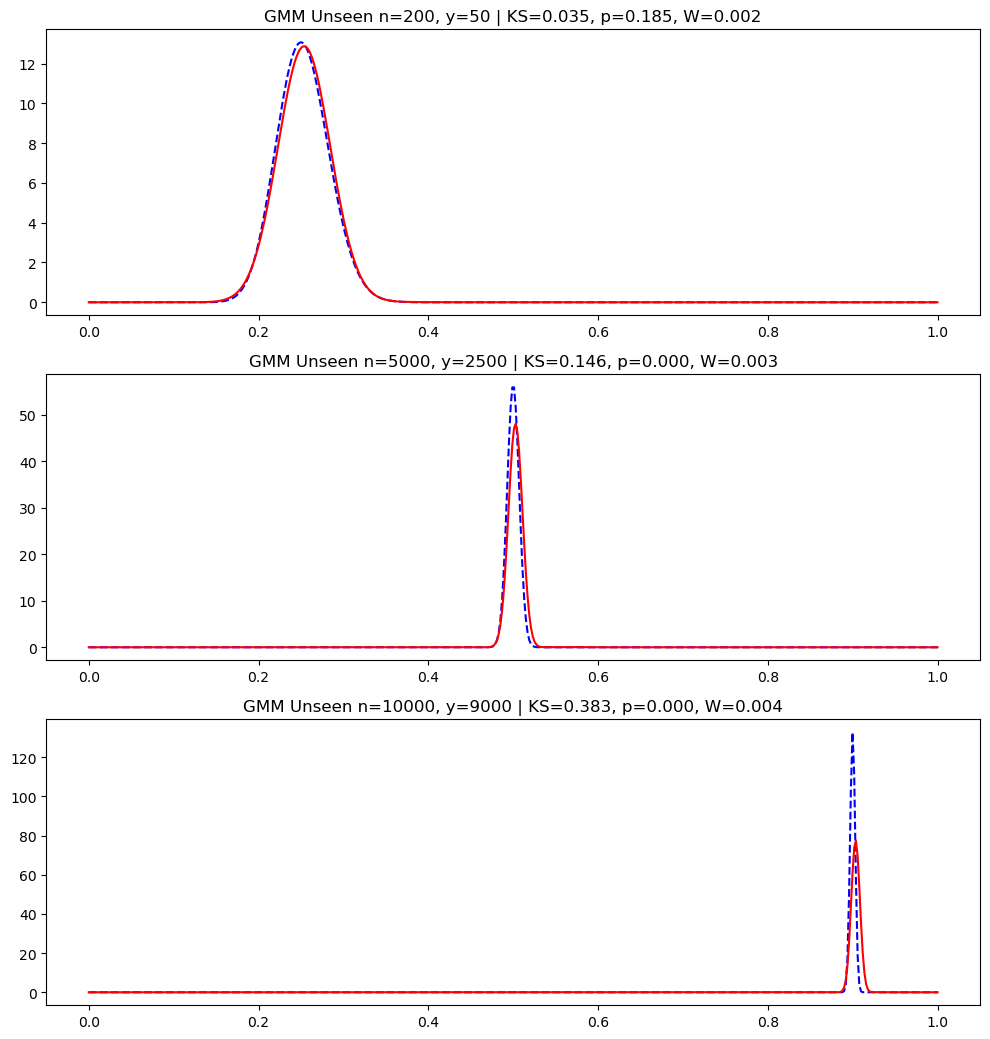

In [5]:
# Evaluation
theta_grid = np.linspace(0, 1, 500)
y_values_fixed = [1, 100, 1000, 2000, 5000]
test_cases_unseen = [(200, 50), (5000, 2500), (10000, 9000)]

print("----- Evaluating GMM Fixed n=5000 -----")
evaluate_gmm_fixed_n(
    model=gmm_model,
    fixed_n=5000,
    y_values=y_values_fixed,
    theta_grid=theta_grid,
    num_components=K
)

print("----- Evaluating GMM Unseen n's -----")
evaluate_gmm_unseen_n(
    model=gmm_model,
    test_cases=test_cases_unseen,
    theta_grid=theta_grid,
    num_components=K
)